# 二.文本聚类

调取需要用的包

In [1]:
import random
import jieba
import jieba.analyse
from gensim.corpora import Dictionary
from gensim import corpora, models
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import multiprocessing
import jieba.posseg as pseg
from sklearn.metrics import silhouette_score  

/anaconda3/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


#       分词、去停用词

In [3]:
text = []
with open('分词结果.txt',encoding="utf-8") as f:
    for line in f:
        text.append(line.strip().split())
lianxiang=text[0:1000]#算头不算尾
xiaomi=text[1000:2000]
apple=text[2000:2999]
huawei=text[2999:]
#将得到的数据集打散
random.shuffle(lianxiang)
random.shuffle(xiaomi)
random.shuffle(apple)
random.shuffle(huawei)

读取一种品牌笔记本的数据

In [4]:
#选择一种笔记本进行分析
doc_list=apple
print(doc_list)

[['让', '失望', '了', '到货', '是', '个', '瑕疵品', '收到', '立马', '要求', '换货', '得', '换'], ['哈哈哈哈', '看', '了', '有', '赠品', '了', '单', '寄过来', '没有', '赠品', '问', '客服', '说', '订单', '没有', '赠品', '说', '看清楚', '了', '赠完', '截止', '说', '是'], ['运行', '速度', '很', '流畅', '屏幕', '效果', '很', '清晰', '散热', '性能', '好', '外形', '外观', '很', '好看', '轻薄', '程度', '很', '轻', '特色', '快递', '力'], ['好', '轻薄', '程度', '运行', '速度', '快', '屏幕', '效果', '不错'], ['运行', '速度', '屏幕', '效果', '清楚', '散热', '性能', '不错', '外形', '外观', '轻薄'], ['价格', '老', '是', '变来变去', '买', '了', '降', '补', '差价'], ['运行', '速度', '算', '不错', '好', '了'], ['苹果', '习惯', '感觉', '苹果', '页面', '是', '友好', '体验', '吧', '还有', '电脑', '做工', '很', '精致'], ['收貨', '降價', '啥意思'], ['满意'], ['电脑', '散热', '很', '容易', '发热', '开', '了', '办公', '软件', '电脑', '发热', '了', '风扇', '声音', '很大', '影响', '工作', '散热', '性能', '差'], ['此', '用户', '未填写', '评价', '内容'], ['质量', '好', '质量', '好', '速度', '快'], ['客服', '说', '充电', '时候', '电脑', '烫手', '唉'], ['外形', '外观', '好'], ['很', '优惠'], ['学生', '认证', '买', '教育', '优惠价', '值', '送', '耳机', '好', '学生', '身份', '送给', '礼物', '赞'], ['退

In [15]:
#另一种分词去停用的方法
 # 函数preprocess_text 用于分词
 # 参数content_lines为初始未分的list
 # 参数sentences是空list，用来储存分词后的数据
def preprocess_text(content_lines,sentences):
        for line in content_lines:
            try:
                segs=jieba.lcut(line)
                segs = [v for v in segs if not str(v).isdigit()]# 去数字
                segs = list(filter(lambda x:x.strip(), segs))# 去左右空格
                segs = list(filter(lambda x:len(x)>1, segs))# 长度为1的字符
                segs = list(filter(lambda x:x not in stopwords, segs))# 去掉停用词
                sentences.append(" ".join(segs))
            except Exception:
                print(line)
                continue
sentences=[]
preprocess_text(doc_list,sentences)
print(sentences)

['让', '失望', '了', '到货', '是', '个', '瑕疵品', '收到', '立马', '要求', '换货', '得', '换']
['哈哈哈哈', '看', '了', '有', '赠品', '了', '单', '寄过来', '没有', '赠品', '问', '客服', '说', '订单', '没有', '赠品', '说', '看清楚', '了', '赠完', '截止', '说', '是']
['运行', '速度', '很', '流畅', '屏幕', '效果', '很', '清晰', '散热', '性能', '好', '外形', '外观', '很', '好看', '轻薄', '程度', '很', '轻', '特色', '快递', '力']
['好', '轻薄', '程度', '运行', '速度', '快', '屏幕', '效果', '不错']
['运行', '速度', '屏幕', '效果', '清楚', '散热', '性能', '不错', '外形', '外观', '轻薄']
['价格', '老', '是', '变来变去', '买', '了', '降', '补', '差价']
['运行', '速度', '算', '不错', '好', '了']
['苹果', '习惯', '感觉', '苹果', '页面', '是', '友好', '体验', '吧', '还有', '电脑', '做工', '很', '精致']
['收貨', '降價', '啥意思']
['满意']
['电脑', '散热', '很', '容易', '发热', '开', '了', '办公', '软件', '电脑', '发热', '了', '风扇', '声音', '很大', '影响', '工作', '散热', '性能', '差']
['此', '用户', '未填写', '评价', '内容']
['质量', '好', '质量', '好', '速度', '快']
['客服', '说', '充电', '时候', '电脑', '烫手', '唉']
['外形', '外观', '好']
['很', '优惠']
['学生', '认证', '买', '教育', '优惠价', '值', '送', '耳机', '好', '学生', '身份', '送给', '礼物', '赞']
['退货', '时候', '拿', '电脑

由之前预处理得到的分词结果进行分段（按品牌）

# TF-IDF（词频矩阵）

In [6]:
# 将文本中的词语转换为词频矩阵 矩阵元素a[i][j] 表示j词在i类文本下的词频
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.7)
  #max_df过滤掉出现太多的无意义词语，如"我"
  #sublinear_tf使用1+log(tf)覆盖tf，来进行线性压缩tf

# 构建一个统计每个词语的tf-idf权值的函数
transformer = TfidfTransformer()

# 第一个fit_transform是计算tf-idf ,然后第二个fit_transform是将文本转为词频矩阵
doc_list_tmp =[str(item) for item in doc_list]
tfidf = transformer.fit_transform(vectorizer.fit_transform(doc_list_tmp))

# 获取词袋模型中的所有词语
word = vectorizer.get_feature_names()

# 将tf-idf矩阵抽取出来，元素w[i][j]表示j词在i类文本中的tf-idf权重
weight = tfidf.toarray()

##查看特征大小
#print('Features length: ' + str(len(word)))
#print(doc_list_tmp)
#print(word)
#print(len(weight[0]))
#print(tfidf)



# 手肘法
利用SSE选择k均值聚类的 k=？

In [7]:
SSE=[]#存放每次误差平方和
for numClass in range(2,30):#######聚类分几簇
    #使用 k-means++ 来初始化模型，这里也可以选择随机初始化init="random"
    clf = KMeans(n_clusters=numClass, max_iter=100000, init="k-means++", tol=pow(10,-6))
    pca = PCA(n_components=10)# 降维
    TnewData = pca.fit_transform(weight)# 载入N维
    s = clf.fit(TnewData)
    SSE.append(clf.inertia_)

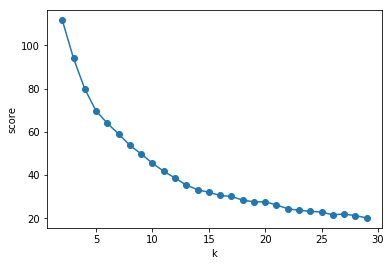

In [8]:
X = range(2,30)  
plt.xlabel('k')  
plt.ylabel('score')  
plt.plot(X,SSE,'o-')  
plt.show()  

# 轮廓系数法

[0.5401709440861324, 0.5611122183952263, 0.5893965069506815, 0.5997340622013537, 0.4665329830852036, 0.5617109454123709, 0.495345071774153, 0.5216570430618922, 0.44403177290738904, 0.44302432730704033, 0.4474827600963989, 0.4474316821193335, 0.47875112601710434, 0.4398234070674747, 0.436042186219122, 0.44028161865608917, 0.36715972759746873, 0.4261440055201436, 0.36055561699749095, 0.4548792770312767, 0.22545153822111497, 0.4555009845199257, 0.4661740516220289, 0.2165534897201021, 0.40599237427329327, 0.20452569054662503, 0.4549336920851566, 0.3392819212474779]


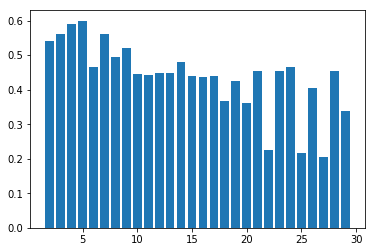

In [9]:
score=[]#存放每次轮廓系数
for numClass in range(2,30):#######聚类分几簇
    #使用 k-means++ 来初始化模型，这里也可以选择随机初始化init="random"
    clf = KMeans(n_clusters=numClass, max_iter=100000, init="k-means++", tol=pow(10,-6))
    pca = PCA(n_components=10)# 降维
    TnewData = pca.fit_transform(weight)# 载入N维
    s = clf.fit(TnewData)
    score.append(silhouette_score(TnewData,clf.labels_,metric='euclidean'))
print(score)
plt.bar(range(2,30),score)  
plt.show()  

用最优的K进行聚类

In [10]:
best_k=2

#使用 k-means++ 来初始化模型，这里也可以选择随机初始化init="random"
clf = KMeans(n_clusters=best_k, max_iter=100000, init="k-means++", tol=pow(10,-6))
# 降维
pca = PCA(n_components=10)
# 载入N维
TnewData = pca.fit_transform(weight)
s = clf.fit(TnewData)

绘制聚类图

In [11]:
#绘制聚类图
def plot_cluster(result,TnewData,numClass):
    plt.figure(2)
    Lab = [[] for i in range(numClass)]
    index = 0
    for labi in result:
        Lab[labi].append(index)
        index += 1
    color = ['oy', 'ob', 'og', 'cs', 'ms', 'bs', 'ks', 'ys', 'yv', 'mv', 'bv', 'kv', 'gv', 'y^', 'm^', 'b^', 'k^','g^'] * 3
    for i in range(numClass):
        x1 = []
        y1 = []
        for ind1 in newData[Lab[i]]:
            # print ind1
            try:
                y1.append(ind1[1])
                x1.append(ind1[0])
            except:
                pass
        plt.plot(x1, y1, color[i])
#绘制初始聚类的中心点
    x1 = []
    y1 = []
    for ind1 in clf.cluster_centers_:
        try:
            y1.append(ind1[1])
            x1.append(ind1[0])
        except:
            pass
    plt.plot(x1, y1, "rv") #绘制中心
    plt.show()

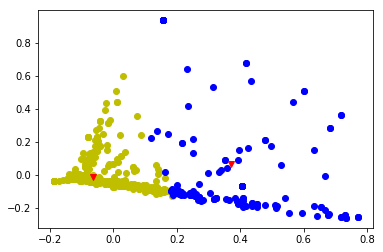

[0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 

In [12]:
pca = PCA(n_components=2)# 输出两维
newData = pca.fit_transform(weight)# 载入N维
result = list(clf.predict(TnewData))#聚类结果，后面有聚类展示
plot_cluster(result,TnewData,numClass)#绘制聚类图（降至两维，展示在第一主成分和第二主成分上的分布情况）
print(result)

In [13]:
cluster0=pd.DataFrame(data=[doc_list,result])
cluster = pd.DataFrame(cluster0.values.T, index=cluster0.columns, columns=['text','class'])

In [16]:
print(cluster[cluster['class'].isin([1])]['text'])

2      [运行, 速度, 很, 流畅, 屏幕, 效果, 很, 清晰, 散热, 性能, 好, 外形, ...
3                     [好, 轻薄, 程度, 运行, 速度, 快, 屏幕, 效果, 不错]
4           [运行, 速度, 屏幕, 效果, 清楚, 散热, 性能, 不错, 外形, 外观, 轻薄]
6                                  [运行, 速度, 算, 不错, 好, 了]
14                                           [外形, 外观, 好]
25                                                  [不错]
29             [运行, 速度, 快, 屏幕, 效果, 好, 散热, 性能, 冷, 外形, 外观]
48     [运行, 速度, 流畅, 屏幕, 效果, 好, 散热, 性能, 外形, 外观, 完美, 轻薄...
54                    [好, 轻薄, 程度, 运行, 速度, 快, 屏幕, 效果, 不错]
58                                           [运行, 速度, 好]
64     [运行, 速度, 快, 散热, 性能, 一般, 外形, 外观, 靓, 轻薄, 程度, 一般,...
69                                           [运行, 速度, 快]
70                               [运行, 速度, 不错, 屏幕, 效果, 好]
72     [运行, 速度, 超快, 屏幕, 效果, 好, 散热, 性能, 好, 外形, 外观, 完美,...
90                               [运行, 速度, 快, 屏幕, 效果, 清晰]
117    [运行, 速度, 屏幕, 效果, 好, 散热, 性能, 很棒, 外形, 外观, 好看, 轻薄...
122             [外形, 外观, 好看, 散热, 性能, 好, 响, 运行, 速度, 好, 快]
132                            

观察k类的个体数占比

In [16]:
type_num=[]
for i in range(best_k):
    type_num.append(result.count(i))
print(type_num)

[151, 848]


# 三.提取关键词 

In [17]:
tmp=cluster[cluster['class'].isin([0])]['text']

# Tf-idf

In [18]:
tags = jieba.analyse.extract_tags(str(tmp),topK = 10)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/vg/01891g0x6m336l7ft09fv9km0000gn/T/jieba.cache
Loading model cost 0.663 seconds.
Prefix dict has been built succesfully.


In [19]:
print("Keywords:","/".join(tags))

Keywords: .../屏幕/散热/效果/电脑/速度/京东/hellip/运行/外观


# Textrank

In [20]:
textrank = jieba.analyse.textrank(str(tmp),topK = 10)

In [21]:
print("Keywords:","/".join(textrank))

Keywords: 电脑/没有/苹果/时候/外观/效果/散热/速度/性能/屏幕


# LDA主题提取

In [22]:
dictionary = corpora.Dictionary(tmp) # 创建语料的词语词典，每个单独的词语都会被赋予一个索引

In [23]:
corpus=[dictionary.doc2bow(i) for i in tmp] 
#corpus[5]  #ictionary.doc2bow只返回文档中有词的对 

In [24]:
#建立TF-IDF模型
tfidf_model=models.TfidfModel(corpus)
#TF-IDF模型加权
corpus_tfidf=tfidf_model[corpus]
#list(corpus_tfidf)


In [25]:
#LDA提取1个主题  
lda = models.ldamodel.LdaModel(corpus=corpus_tfidf, id2word=dictionary,
                               num_topics=1, update_every=0, passes=60)
#text:文本，已经表示成词袋了。 num_topics: 提取的主题数 id2word:词典 passes:类似于在机器学习中常见的epoch，也就是训练了多少轮

In [26]:
lda.show_topic(0)

[('好', 0.007568459),
 ('了', 0.0062333182),
 ('很', 0.005095365),
 ('速度', 0.0047473395),
 ('不错', 0.004551759),
 ('买', 0.00443567),
 ('运行', 0.004185873),
 ('是', 0.0040017483),
 ('外观', 0.0039953124),
 ('屏幕', 0.0035945752)]